**Problem Description: Dynamic Pricing as a Non-Stationary Multi-Armed Bandits**

The seller has a set of discrete price options $\{p_1, p_2, p_3, p_4\}$, e.g., $\{5, 10, 15, 20\}$ currency units. The probability of a customer purchasing the product at each price varies over time. The goal is to maximize revenue (or minimize regret) by adaptively choosing prices based on observed purchases. Below we simulate this situation.

You will have to implement and test two algorithms for the non-stationary multi-armed bandit problem DiscountedUCB and SlidingWindowUCB from the paper [On Upper-Confidence Bound Policies for Non-Stationary Bandit Problems](https://arxiv.org/pdf/0805.3415) by Garivier and Moulines.

**Defining the environment with abrupt changes**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class DynamicPricingEnv:
    def __init__(self, prices, change_points, reward_probabilities):
        self.prices = prices
        self.change_points = change_points
        self.reward_probabilities = reward_probabilities
        self.current_phase = 0
        self.t = 0

    def step(self, price_index):
        if self.t in self.change_points:
            self.current_phase = min(self.current_phase + 1, len(self.reward_probabilities) - 1)

        self.t += 1
        return np.random.rand() < self.reward_probabilities[self.current_phase][price_index]

    def reset(self):
        self.current_phase = 0
        self.t = 0


**Plotting the bernoulli reward probability for each arm**

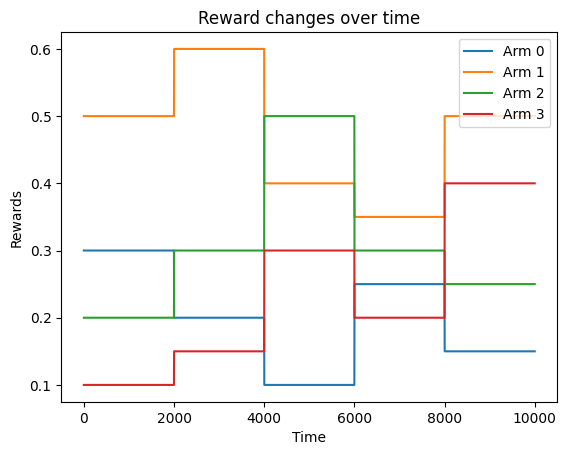

In [ ]:
prices = [5, 10, 15, 20]
change_points = [2000, 4000, 6000, 8000]
reward_probabilities = [
    [0.3, 0.5, 0.2, 0.1],  # Phase 1
    [0.2, 0.6, 0.3, 0.15], # Phase 2
    [0.1, 0.4, 0.5, 0.3],  # Phase 3
    [0.25, 0.35, 0.3, 0.2], # Phase 4
    [0.15, 0.5, 0.25, 0.4]  # Phase 5
]
env = DynamicPricingEnv(prices, change_points, reward_probabilities)
T = 10000

rewards = [[] for i in range(len(prices))]

for t in range(T):
  env.step(0)
  for i in range(len(prices)):
    rewards[i].append(env.reward_probabilities[env.current_phase][i])

for i in range(len(prices)):
  x = list(range(len(rewards[i])))  # Generate x-values
  plt.plot(x, rewards[i], label='Arm ' + str(i))

plt.xlabel("Time")
plt.ylabel("Rewards")
plt.legend()
plt.title("Reward changes over time")
plt.savefig("Env_1_rewards")

**Sliding Window UCB**

In [ ]:
class SlidingWindowUCB:
    def __init__(self, n_arms, window_size):
        self.n_arms = n_arms
        self.window_size = window_size
        self.rewards = []
        self.B = 1
        self.E = 0.6

    def select_arm(self):
      total = len(self.rewards)
      n_t = np.zeros(self.n_arms)
      nu_t = np.zeros(self.n_arms)
      ucb_t = np.zeros(self.n_arms)
      for i in range(len(self.rewards)):
        n_t[self.rewards[i][0]] += 1
        nu_t[self.rewards[i][0]] += self.rewards[i][1]

      for i in range(self.n_arms):
        if n_t[i] == 0:
          return i
        ucb_t[i] = nu_t[i] / n_t[i] + self.B * np.sqrt(self.E * np.log(total) / n_t[i])
      return np.argmax(ucb_t)


    def update(self, arm, reward):
      self.rewards.append([arm, reward])
      if len(self.rewards) > self.window_size:
        self.rewards.pop(0)

**Discounted UCB**

In [ ]:
class DiscountedUCB:
    def __init__(self, n_arms, gamma, E):
        self.n_arms = n_arms
        self.gamma = gamma
        self.rewards = []
        self.n_t = np.zeros(n_arms)
        self.B = 1
        self.E = E


    def select_arm(self):
      total = 0

      n_t_d = np.zeros(self.n_arms)
      nu_t = np.zeros(self.n_arms)
      ucb_t = np.zeros(self.n_arms)
      gamma_multiplier = 1
      for i in range(len(self.rewards)-1,-1,-1):

        n_t_d[self.rewards[i][0]] += 1*gamma_multiplier
        nu_t[self.rewards[i][0]] += self.rewards[i][1]*gamma_multiplier
        total += 1*gamma_multiplier
        gamma_multiplier *= self.gamma

      for i in range(self.n_arms):
        if n_t_d[i] == 0:
          return i
        ucb_t[i] = nu_t[i] / n_t_d[i] + self.B * np.sqrt(self.E * np.log(total) / n_t_d[i])

      return np.argmax(ucb_t)


    def update(self, arm, reward):
      self.rewards.append([arm, reward])



**Experiment 1: Plotting Regret for SW-UCB and Discounted-UCB**

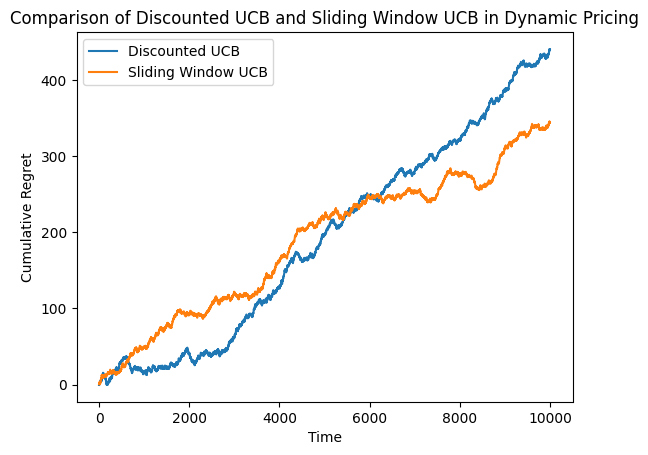

In [ ]:

#Defining Environment
env_d = DynamicPricingEnv(prices, change_points, reward_probabilities)
env_sw = DynamicPricingEnv(prices, change_points, reward_probabilities)

# Instance of Algorithm
d_ucb = DiscountedUCB(len(prices),0.9975,0.6)
sw_ucb = SlidingWindowUCB(len(prices),1213)

T = 10000
regrets_d = []
regrets_sw = []
regrets_s =[]

for t in range(T):


    # Discounted UCB
    arm_d = d_ucb.select_arm()
    reward_d = env_d.step(arm_d)
    d_ucb.update(arm_d, reward_d)
    regrets_d.append(max(reward_probabilities[env_d.current_phase]) - reward_d)


    # Sliding Window UCB
    arm_sw = sw_ucb.select_arm()
    reward_sw = env_sw.step(arm_sw)
    sw_ucb.update(arm_sw, reward_sw)
    regrets_sw.append(max(reward_probabilities[env_sw.current_phase]) - reward_sw)



# Plot Regrets
plt.plot(np.cumsum(regrets_d), label='Discounted UCB')
plt.plot(np.cumsum(regrets_sw), label='Sliding Window UCB')
#plt.plot(np.cumsum(regrets_s), label='UCB_s')
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.title("Comparison of Discounted UCB and Sliding Window UCB in Dynamic Pricing")
plt.savefig("Env_1_regret")




**Experiment 2: Behaviour of the alorithms with different parameters.**

A. SW-UCB

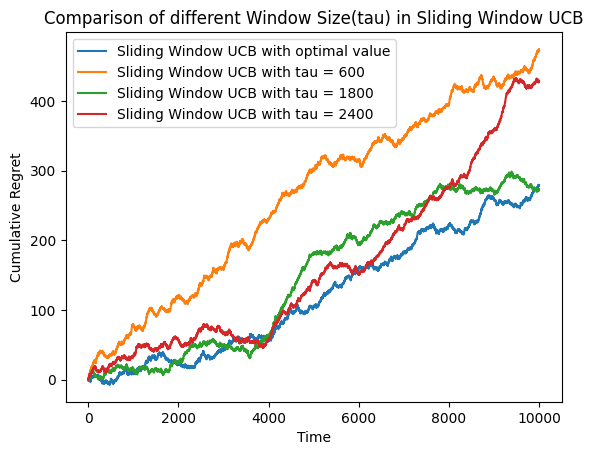

In [ ]:
env_sw_og = DynamicPricingEnv(prices, change_points, reward_probabilities)
env_sw_6 = DynamicPricingEnv(prices, change_points, reward_probabilities)
env_sw_18 = DynamicPricingEnv(prices, change_points, reward_probabilities)
env_sw_24 = DynamicPricingEnv(prices, change_points, reward_probabilities)
sw_ucb_og = SlidingWindowUCB(len(prices),1213)
sw_ucb_6 = SlidingWindowUCB(len(prices),600)
sw_ucb_18 = SlidingWindowUCB(len(prices),1800)
sw_ucb_24 = SlidingWindowUCB(len(prices),2400)

T = 10000
regrets_sw_og = []
regrets_sw_6 = []
regrets_sw_18 = []
regrets_sw_24 = []

for t in range(T):
    # Sliding Window UCB with optimal parameters
    arm_sw = sw_ucb_og.select_arm()
    reward_sw = env_sw_og.step(arm_sw)
    sw_ucb_og.update(arm_sw, reward_sw)
    regrets_sw_og.append(max(reward_probabilities[env_sw_og.current_phase]) - reward_sw)

    # Sliding Window UCB with tau = 600
    arm_sw = sw_ucb_6.select_arm()
    reward_sw = env_sw_6.step(arm_sw)
    sw_ucb_6.update(arm_sw, reward_sw)
    regrets_sw_6.append(max(reward_probabilities[env_sw_6.current_phase]) - reward_sw)

    # Sliding Window UCB with tau = 1800
    arm_sw = sw_ucb_18.select_arm()
    reward_sw = env_sw_18.step(arm_sw)
    sw_ucb_18.update(arm_sw, reward_sw)
    regrets_sw_18.append(max(reward_probabilities[env_sw_18.current_phase]) - reward_sw)

    # Sliding Window UCB with tau = 2400
    arm_sw = sw_ucb_24.select_arm()
    reward_sw = env_sw_24.step(arm_sw)
    sw_ucb_24.update(arm_sw, reward_sw)
    regrets_sw_24.append(max(reward_probabilities[env_sw_24.current_phase]) - reward_sw)



# Plot Regrets

plt.plot(np.cumsum(regrets_sw_og), label='Sliding Window UCB with optimal value')
plt.plot(np.cumsum(regrets_sw_6), label='Sliding Window UCB with tau = 600')
plt.plot(np.cumsum(regrets_sw_18), label='Sliding Window UCB with tau = 1800')
plt.plot(np.cumsum(regrets_sw_24), label='Sliding Window UCB with tau = 2400')
#plt.plot(np.cumsum(regrets_s), label='UCB_s')
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.title("Comparison of different Window Size(tau) in Sliding Window UCB")
plt.savefig("SlidingWindow_regret_different_tau")



B. Discounted UCB

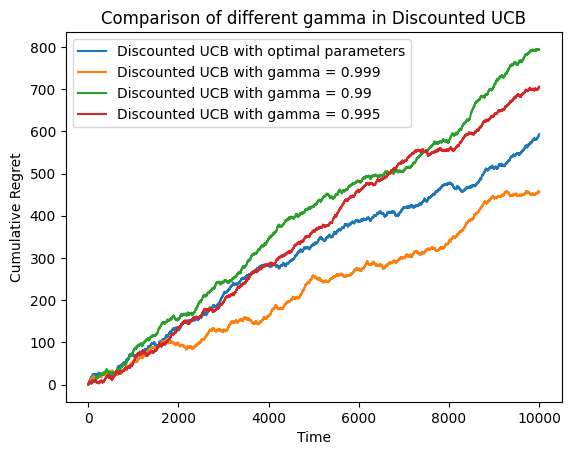

In [ ]:

d_ucb_og = DiscountedUCB(len(prices),0.9975,0.6)
d_ucb_99 = DiscountedUCB(len(prices),0.999,0.6)
d_ucb_9 = DiscountedUCB(len(prices),0.99,0.6)
d_ucb_95 = DiscountedUCB(len(prices),0.995,0.6)

env_d_og = DynamicPricingEnv(prices, change_points, reward_probabilities)
env_d_99 = DynamicPricingEnv(prices, change_points, reward_probabilities)
env_d_9 = DynamicPricingEnv(prices, change_points, reward_probabilities)
env_d_95 = DynamicPricingEnv(prices, change_points, reward_probabilities)

T = 10000
regrets_d_og = []
regrets_d_99 = []
regrets_d_9 = []
regrets_d_95 = []


for t in range(T):

    # Discounted UCB optimal parameters
    arm_d = d_ucb_og.select_arm()
    reward_d = env_d_og.step(arm_d)
    d_ucb_og.update(arm_d, reward_d)
    regrets_d_og.append(max(reward_probabilities[env_d_og.current_phase]) - reward_d)

    # Discounted UCB with gamma = 0.999
    arm_d = d_ucb_99.select_arm()
    reward_d = env_d_99.step(arm_d)
    d_ucb_99.update(arm_d, reward_d)
    regrets_d_99.append(max(reward_probabilities[env_d_99.current_phase]) - reward_d)

    # Discounted UCB with gamma = 0.995
    arm_d = d_ucb_95.select_arm()
    reward_d = env_d_95.step(arm_d)
    d_ucb_95.update(arm_d, reward_d)
    regrets_d_95.append(max(reward_probabilities[env_d_95.current_phase]) - reward_d)

    # Discounted UCB with gamma = 0.99
    arm_d = d_ucb_9.select_arm()
    reward_d = env_d_9.step(arm_d)
    d_ucb_9.update(arm_d, reward_d)
    regrets_d_9.append(max(reward_probabilities[env_d_9.current_phase]) - reward_d)



# Plot Regrets
plt.plot(np.cumsum(regrets_d_og), label='Discounted UCB with optimal parameters')
plt.plot(np.cumsum(regrets_d_99), label='Discounted UCB with gamma = 0.999')
plt.plot(np.cumsum(regrets_d_9), label='Discounted UCB with gamma = 0.99')
plt.plot(np.cumsum(regrets_d_95), label='Discounted UCB with gamma = 0.995')

#plt.plot(np.cumsum(regrets_s), label='UCB_s')
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.title("Comparison of different gamma in Discounted UCB")
plt.savefig("Discounted_regret_different_gamma")

**Experiment 3: Introducting more prices ie more arms in the MAB problem**

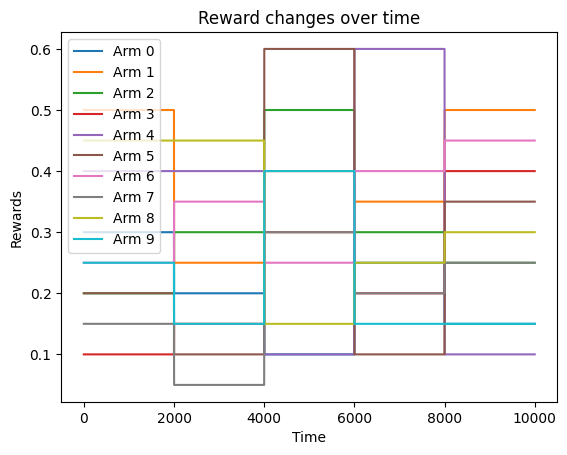

In [ ]:
# Experiment Setup
prices = [5, 10, 15, 20, 25, 30, 15, 20, 25, 30]
change_points = [2000, 4000, 6000, 8000]
reward_probabilities = [
    [0.3, 0.5, 0.2, 0.1, 0.4, 0.2, 0.25, 0.15, 0.45, 0.25],  # Phase 1
    [0.2, 0.25, 0.3, 0.15, 0.4, 0.1, 0.35, 0.05, 0.45, 0.15], # Phase 2
    [0.1, 0.4, 0.5, 0.3 , 0.1, 0.6, 0.25, 0.3, 0.15, 0.4],  # Phase 3
    [0.25, 0.35, 0.3, 0.2, 0.6, 0.1, 0.4, 0.2, 0.25, 0.15], # Phase 4
    [0.15, 0.5, 0.25, 0.4, 0.1, 0.35, 0.45, 0.25, 0.3, 0.15]  # Phase 5
]


env = DynamicPricingEnv(prices, change_points, reward_probabilities)
T = 10000

rewards = [[] for i in range(len(prices))]

for t in range(T):
  env.step(0)
  for i in range(len(prices)):
    rewards[i].append(env.reward_probabilities[env.current_phase][i])

for i in range(len(prices)):
  x = list(range(len(rewards[i])))  # Generate x-values
  plt.plot(x, rewards[i], label='Arm ' + str(i))
plt.figure(1)
plt.xlabel("Time")
plt.ylabel("Rewards")
plt.legend()
plt.title("Reward changes over time")
plt.savefig("Env_1_rewards_newPrices")

Discounted UCB

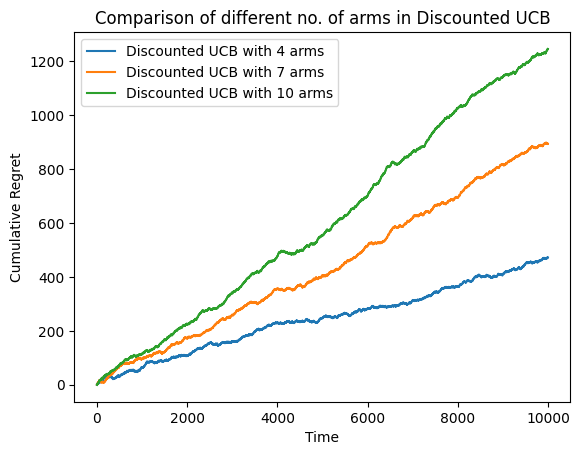

In [ ]:
reward_probabilities_4 = [i[0:4] for i in reward_probabilities]
reward_probabilities_7 = [i[0:7] for i in reward_probabilities]
reward_probabilities_10 = reward_probabilities

#Defining Environment
env_d_4 = DynamicPricingEnv(prices[0:4], change_points, reward_probabilities_4)
env_d_7 = DynamicPricingEnv(prices[0:7], change_points, reward_probabilities_7)
env_d_10 = DynamicPricingEnv(prices, change_points, reward_probabilities_10)

# Instance of Algorithm
d_ucb_4 = DiscountedUCB(4,0.9975,0.6)
d_ucb_7 = DiscountedUCB(7,0.9975,0.6)
d_ucb_10 = DiscountedUCB(10,0.9975,0.6)

T = 10000
regrets_d_4 = []
regrets_d_7 = []
regrets_d_10 = []



for t in range(T):


    # Discounted UCB with 4 Arms
    arm_d = d_ucb_4.select_arm()
    reward_d = env_d_4.step(arm_d)
    d_ucb_4.update(arm_d, reward_d)
    regrets_d_4.append(max(reward_probabilities_4[env_d_4.current_phase]) - reward_d)

    # Discounted UCB with 7 arms
    arm_d = d_ucb_7.select_arm()
    reward_d = env_d_7.step(arm_d)
    d_ucb_7.update(arm_d, reward_d)
    regrets_d_7.append(max(reward_probabilities_7[env_d_7.current_phase]) - reward_d)

    # Discounted UCB with 10 arms
    arm_d = d_ucb_10.select_arm()
    reward_d = env_d_10.step(arm_d)
    d_ucb_10.update(arm_d, reward_d)
    regrets_d_10.append(max(reward_probabilities_10[env_d_10.current_phase]) - reward_d)



# Plot Regrets
plt.figure(2)
plt.plot(np.cumsum(regrets_d_4), label='Discounted UCB with 4 arms')
plt.plot(np.cumsum(regrets_d_7), label='Discounted UCB with 7 arms')
plt.plot(np.cumsum(regrets_d_10), label='Discounted UCB with 10 arms')

#plt.plot(np.cumsum(regrets_s), label='UCB_s')
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.title("Comparison of different no. of arms in Discounted UCB")
plt.savefig("Regret_newPrices_Discounted")

SW-UCB

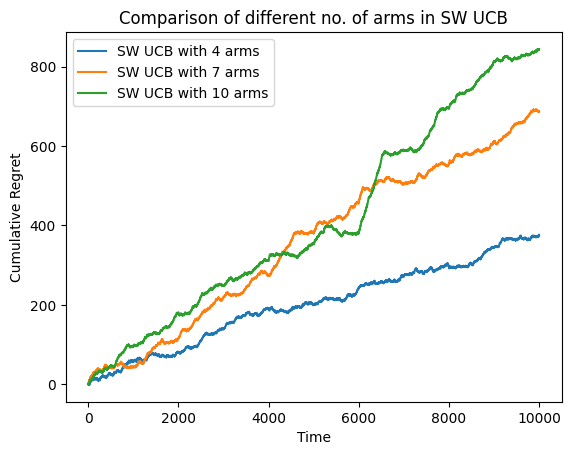

In [ ]:
reward_probabilities_4 = [i[0:4] for i in reward_probabilities]
reward_probabilities_7 = [i[0:7] for i in reward_probabilities]
reward_probabilities_10 = reward_probabilities

#Defining Environment
env_s_4 = DynamicPricingEnv(prices[0:4], change_points, reward_probabilities_4)
env_s_7 = DynamicPricingEnv(prices[0:7], change_points, reward_probabilities_7)
env_s_10 = DynamicPricingEnv(prices, change_points, reward_probabilities_10)

# Instance of Algorithm
s_ucb_4 = SlidingWindowUCB(4,1213)
s_ucb_7 = SlidingWindowUCB(7,1213)
s_ucb_10 = SlidingWindowUCB(10,1213)

T = 10000
regrets_s_4 = []
regrets_s_7 = []
regrets_s_10 = []



for t in range(T):


    # Sliding Window UCB with 4 Arms
    arm_s = s_ucb_4.select_arm()
    reward_s = env_s_4.step(arm_s)
    s_ucb_4.update(arm_s, reward_s)
    regrets_s_4.append(max(reward_probabilities_4[env_s_4.current_phase]) - reward_s)

    # Sliding Window UCB with 7 arms
    arm_s = s_ucb_7.select_arm()
    reward_s = env_s_7.step(arm_s)
    s_ucb_7.update(arm_s, reward_s)
    regrets_s_7.append(max(reward_probabilities_7[env_s_7.current_phase]) - reward_s)

    # Sliding Window UCB with 10 arms
    arm_s = s_ucb_10.select_arm()
    reward_s = env_s_10.step(arm_s)
    s_ucb_10.update(arm_s, reward_s)
    regrets_s_10.append(max(reward_probabilities_10[env_s_10.current_phase]) - reward_s)



# Plot Regrets
plt.figure(2)
plt.plot(np.cumsum(regrets_s_4), label='SW UCB with 4 arms')
plt.plot(np.cumsum(regrets_s_7), label='SW UCB with 7 arms')
plt.plot(np.cumsum(regrets_s_10), label='SW UCB with 10 arms')

#plt.plot(np.cumsum(regrets_s), label='UCB_s')
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.title("Comparison of different no. of arms in SW UCB")
plt.savefig("Regret_newPrices_SW")

**Introducing New Environment with Gradual changes in Reward Probability**

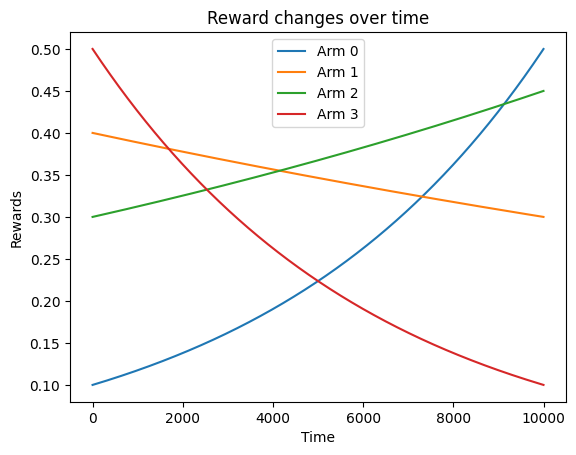

In [ ]:
class DynamicPricingEnv_gradual:
    def __init__(self, prices, init_probability, change_factors):
        self.prices = prices
        self.change_factors = change_factors
        self.init_probability = init_probability
        self.t = 0
        self.reward_probabilities = init_probability[:]

    def step(self, arm):
        for i in range(len(self.reward_probabilities)):
            self.reward_probabilities[i] = self.init_probability[i]*((self.change_factors[i])**(self.t))

        self.t += 1

        curr_prob = self.init_probability[arm]
        curr_prob *= (self.change_factors[arm])**(self.t)

        return np.random.rand() < curr_prob

    def reset(self):
        self.current_phase = 0
        self.t = 0


prices = [5, 10, 15, 20]
init_probability = [0.1, 0.4, 0.3, 0.5]
change_factors = [i**(1/10000) for i in [5, 3/4, 3/2, 1/5]]

env_grad = DynamicPricingEnv_gradual(prices, init_probability, change_factors)
T = 10000

rewards = [[] for i in range(len(prices))]

for t in range(T):
  env_grad.step(0)
  for i in range(len(prices)):
    rewards[i].append(env_grad.reward_probabilities[i])

for i in range(len(prices)):
  plt.plot(rewards[i], label='Arm ' + str(i))
plt.xlabel("Time")
plt.ylabel("Rewards")
plt.legend()
plt.title("Reward changes over time")
plt.savefig("Env_2_rewards")

**Experiment 4: Plotting Regret for SW-UCB and Discounted-UCB**

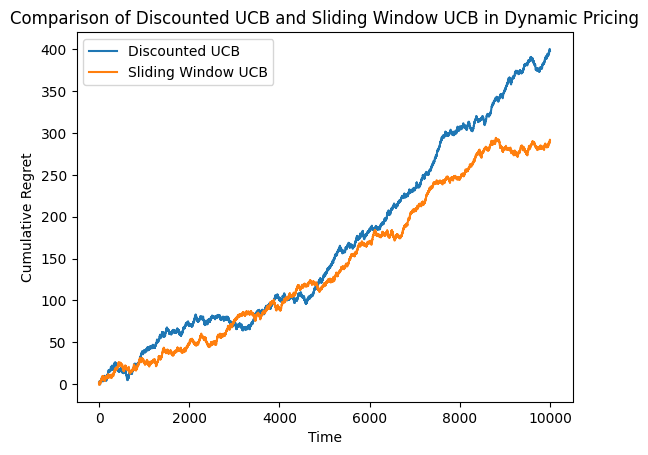

In [ ]:
env_d = DynamicPricingEnv_gradual(prices, init_probability, change_factors)
env_sw = DynamicPricingEnv_gradual(prices, init_probability,change_factors)

d_ucb = DiscountedUCB(len(prices),0.9975,0.6)
sw_ucb = SlidingWindowUCB(len(prices),1213)

T = 10000
regrets_d = []
regrets_sw = []
regrets_s =[]

for t in range(T):

    # Discounted UCB
    arm_d = d_ucb.select_arm()
    reward_d = env_d.step(arm_d)
    d_ucb.update(arm_d, reward_d)
    regrets_d.append(max(env_d.reward_probabilities) - reward_d)


    # Sliding Window UCB
    arm_sw = sw_ucb.select_arm()
    reward_sw = env_sw.step(arm_sw)
    sw_ucb.update(arm_sw, reward_sw)
    regrets_sw.append(max(env_sw.reward_probabilities) - reward_sw)


# Plot Regrets
plt.plot(np.cumsum(regrets_d), label='Discounted UCB')
plt.plot(np.cumsum(regrets_sw), label='Sliding Window UCB')
#plt.plot(np.cumsum(regrets_s), label='UCB_s')
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.title("Comparison of Discounted UCB and Sliding Window UCB in Dynamic Pricing")
plt.savefig("Env_2_regret")

